In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from sklearn import preprocessing
from sklearn import svm, datasets,metrics
from sklearn.model_selection import train_test_split
from scipy.stats import stats, chi2_contingency
from sklearn.metrics import average_precision_score, recall_score, accuracy_score
from tqdm.notebook import tqdm

L’objectif du projet est de construire un code structuré et fonctionnel en python. Ce code doit permettre de faire une prédiction sur le jeu de données Auto Insurance qui a pour cible TARGET_FLAG. Ce code devra donner explicitement la valeur de la performance des algorithmes employés avec une métrique adaptée et produire un fichier au format csv avec les prédictions.
La performance n’est pas l’élément le plus important. L’objectif du projet est de rédiger les étapes principales d’un projet de data-science en 2 heures de travail en soignant la mise en forme et les commentaires.
Il faudra nous transmettre le code sous la forme de fichiers python ou ipython notebook utilisant les librairies adaptées par un lien vers un repo github.

In [24]:
#preparation de la data
def prep_data(path):
    features = pd.read_csv(path)
    #on binarise les variables "yes/no"
    features.replace({"yes": 1,"no":0,"Yes":1,"z_No":0,"M":0,"z_F":1,"No":0}, inplace=True)
    
    #on supprime les symboles "$" et on transforme les "," en "." pour convertir la colonne de string en float
    features.replace({"\$":"",",":"."},regex=True,inplace=True)
    
    #on laisse tomber la colonne 'TARGET_AMT' car elle est vide dans la base de test et 'INDEX' car peu utile en prédiction et analyse
    features.drop(['TARGET_AMT'],axis='columns',inplace=True) 
    features.drop(['INDEX'],axis='columns',inplace=True)
    
    return(features)

features = prep_data('train_auto.csv')
features.describe()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,PARENT1,MSTATUS,SEX,TRAVTIME,TIF,RED_CAR,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,0.263816,0.171057,44.790313,0.721235,10.499286,0.131969,0.599681,0.536086,33.485725,5.351305,0.291386,0.798554,0.122534,1.695503,8.328323
std,0.440728,0.511534,8.627589,1.116323,4.092474,0.338478,0.489993,0.498727,15.908333,4.146635,0.454429,1.158453,0.327922,2.147112,5.700742
min,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-3.000000
25%,0.000000,0.000000,39.000000,0.000000,9.000000,0.000000,0.000000,0.000000,22.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,45.000000,0.000000,11.000000,0.000000,1.000000,1.000000,33.000000,4.000000,0.000000,0.000000,0.000000,1.000000,8.000000
75%,1.000000,0.000000,51.000000,1.000000,13.000000,0.000000,1.000000,1.000000,44.000000,7.000000,1.000000,2.000000,0.000000,3.000000,12.000000
max,1.000000,4.000000,81.000000,5.000000,23.000000,1.000000,1.000000,1.000000,142.000000,25.000000,1.000000,5.000000,1.000000,13.000000,28.000000


In [25]:
#on fait ressortir toutes les variables qualitatives de la base données pour voir celles qu'on peut 
#déjà convertir en colonnes de flottants 
def dollars(features):
    l_obj = []
    for i in range(len(features.dtypes)):
        if features.dtypes[i] == 'object':
            l_obj.append(features.columns[i])
            features[l_obj]
    print(l_obj)
    return(l_obj)
l = dollars(features)

['INCOME', 'HOME_VAL', 'EDUCATION', 'JOB', 'CAR_USE', 'BLUEBOOK', 'CAR_TYPE', 'OLDCLAIM', 'URBANICITY']


In [26]:
features[l]

,INCOME,HOME_VAL,EDUCATION,JOB,CAR_USE,BLUEBOOK,CAR_TYPE,OLDCLAIM,URBANICITY
0,67.349,0,PhD,Professional,Private,14.230,Minivan,4.461,Highly Urban/ Urban
1,91.449,257.252,z_High School,z_Blue Collar,Commercial,14.940,Minivan,0,Highly Urban/ Urban
2,16.039,124.191,z_High School,Clerical,Private,4.010,z_SUV,38.690,Highly Urban/ Urban
3,NaN,306.251,<High School,z_Blue Collar,Private,15.440,Minivan,0,Highly Urban/ Urban
4,114.986,243.925,PhD,Doctor,Private,18.000,z_SUV,19.217,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...
8156,43.112,0,z_High School,z_Blue Collar,Commercial,27.330,Panel Truck,0,z_Highly Rural/ Rural
8157,164.669,386.273,PhD,Manager,Private,13.270,Minivan,0,Highly Urban/ Urban
8158,107.204,332.591,Masters,NaN,Commercial,24.490,Panel Truck,0,Highly Urban/ Urban
8159,43.445,149.248,Bachelors,Home Maker,Private,22.550,Minivan,0,Highly Urban/ Urban


On voit ici que les colonnes INCOME, OLDCLAIM, BLUEBOOK et HOME_VAL ne sont actuellement pas considérées comme des colonnes de valeurs numériques. Cela est dû au fait que les valeurs de ces colonnes étaient sous la forme "$xx,xx" et on récemment été changées mais pas encore converties.

In [27]:
#on convertit les colonnes numériques en colonnes de flottant
features['OLDCLAIM'] = features['OLDCLAIM'].astype(float)
features['BLUEBOOK'] = features['BLUEBOOK'].astype(float)
features['INCOME'] = features['INCOME'].astype(float)
features['HOME_VAL'] = features['HOME_VAL'].astype(float)

#one hot encoding sur le DataFrame pour binariser les variables qualitatives
features = pd.get_dummies(features)
features.describe()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,CAR_USE_Commercial,CAR_USE_Private,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,URBANICITY_Highly Urban/ Urban,URBANICITY_z_Highly Rural/ Rural
count,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,7716.000000,8161.000000,7697.000000,8161.000000,8161.000000,...,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000
mean,0.263816,0.171057,44.790313,0.721235,10.499286,64.757855,0.131969,154.867290,0.599681,0.536086,...,0.371155,0.628845,0.262835,0.082833,0.170200,0.111138,0.091901,0.281093,0.795491,0.204509
std,0.440728,0.511534,8.627589,1.116323,4.092474,60.768449,0.338478,129.123775,0.489993,0.498727,...,0.483144,0.483144,0.440201,0.275646,0.375831,0.314323,0.288903,0.449560,0.403367,0.403367
min,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,39.000000,0.000000,9.000000,28.696250,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,45.000000,0.000000,11.000000,54.799500,0.000000,161.160000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,51.000000,1.000000,13.000000,87.259000,0.000000,238.724000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,4.000000,81.000000,5.000000,23.000000,997.000000,1.000000,885.282000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


La base de données semble désormais beaucoup plus lisible, cependant elle semble contenir beaucoup de valeurs nan. Nous allons regarder si ces valeurs manquantes sont importantes à corriger ou s'il est possible de simplement les retirer.

In [28]:
dfeatures = features.dropna() 
avec_nan = np.count_nonzero(features['TARGET_FLAG'])
print(f"TARGET_FLAG = 1: {avec_nan},TARGET_FLAG = 0: {len(features)-avec_nan},\tSoit:  TARGET_FLAG = 1: {round(avec_nan*100/len(features),3)}%, TARGET_FLAG = 0: {round((avec_nan - len(features))*100/len(features),3)}%")
sans_nan = np.count_nonzero(dfeatures['TARGET_FLAG'])
print(f"TARGET_FLAG = 1: {sans_nan},TARGET_FLAG = 0: {len(dfeatures)-sans_nan},\tSoit:  TARGET_FLAG = 1: {round(sans_nan*100/len(dfeatures),3)}%, TARGET_FLAG = 0: {round((sans_nan - len(dfeatures))*100/len(dfeatures),3)}%")

TARGET_FLAG = 1: 2153,TARGET_FLAG = 0: 6008,	Soit:  TARGET_FLAG = 1: 26.382%, TARGET_FLAG = 0: -73.618%
TARGET_FLAG = 1: 1703,TARGET_FLAG = 0: 4745,	Soit:  TARGET_FLAG = 1: 26.411%, TARGET_FLAG = 0: -73.589%


On voit que presque la moitié des lignes où des valeurs manque se trouve dans les cas où TARGET_FLAG = 1, or la base de donnée sans manquants garde le même équilibre que l'originale. Cette base est d'ailleurs très déséquilibrée, ce qu'il va falloir prendre en compte dans la suite pour la prédiction. Mais nous pouvons continuer avec la base sans valeurs manquantes car elle est aussi équilibrée que l'originale.

Nous pouvons ensuite effectuer des test statistiques sur la base de données pour voir s'il y a des variables que l'on peut déjà retirer car elles ne sont pas très pertinentes.

In [29]:
def noms(data_step):
    #récupère les variables binaires pour les tests statistiques à venir
    binaire = []
    for i in data_step.columns:
        if (data_step[i].min() == 0) & (data_step[i].max() == 1):
            binaire.append(i)
    return(binaire)

def chideux(pandas_df,binaire):
    #test statistique du chi2 appliqué aux variables binaires
    nega, posi = pandas_df[pandas_df['TARGET_FLAG'] == 0], pandas_df[pandas_df['TARGET_FLAG'] == 1]
    for i in pandas_df.columns:
        if i in binaire:
            contin = np.zeros((2,2))
            contin[0,0]=np.count_nonzero(posi[i])
            contin[1,0]=len(posi)-np.count_nonzero(posi[i])
            contin[0,1]=np.count_nonzero(nega[i])
            contin[1,1]=len(nega)-np.count_nonzero(nega[i])
            print(round(chi2_contingency(contin)[1],3),i)

def statistique(pandas_df,binaire):
    #test de Student pour les variables quantitatives normales 
    #et test de Mann Whitney pour les autres variables quantitatives
    nega, posi = pandas_df[pandas_df['TARGET_FLAG'] == 0], pandas_df[pandas_df['TARGET_FLAG'] == 1]
    for i in pandas_df.columns:
        if i not in binaire:
            if (int(posi[i].mean()) == int(np.percentile(posi[i],50))) & (int(nega[i].mean()) == int(np.percentile(nega[i],50))):
                #test Student 
                z = stats.ttest_ind(nega[i],posi[i])
                print(round(z[1],3),i,"Student")
            else:
                z = stats.mannwhitneyu(nega[i],posi[i])
                print(round(z[1],3),i,"Mann Whitney")

binaire = noms(dfeatures)
print("\nTests statistiques quantitatifs\n")
statistique(dfeatures,binaire)
print("\nTests du Chi-Square qualitatifs\n")
chideux(dfeatures,binaire)


Tests statistiques quantitatifs

0.0 KIDSDRIV Student
0.0 AGE Mann Whitney
0.0 HOMEKIDS Student
0.0 YOJ Mann Whitney
0.0 INCOME Mann Whitney
0.0 HOME_VAL Mann Whitney
0.0 TRAVTIME Mann Whitney
0.0 BLUEBOOK Mann Whitney
0.0 TIF Mann Whitney
0.0 OLDCLAIM Mann Whitney
0.0 CLM_FREQ Student
0.0 MVR_PTS Student
0.0 CAR_AGE Mann Whitney

Tests du Chi-Square qualitatifs

0.0 TARGET_FLAG
0.0 PARENT1
0.0 MSTATUS
0.091 SEX
0.224 RED_CAR
0.0 REVOKED
0.0 EDUCATION_<High School
0.0 EDUCATION_Bachelors
0.0 EDUCATION_Masters
0.0 EDUCATION_PhD
0.0 EDUCATION_z_High School
0.003 JOB_Clerical
0.0 JOB_Doctor
0.617 JOB_Home Maker
0.0 JOB_Lawyer
0.0 JOB_Manager
0.001 JOB_Professional
0.0 JOB_Student
0.0 JOB_z_Blue Collar
0.0 CAR_USE_Commercial
0.0 CAR_USE_Private
0.0 CAR_TYPE_Minivan
0.753 CAR_TYPE_Panel Truck
0.0 CAR_TYPE_Pickup
0.0 CAR_TYPE_Sports Car
0.992 CAR_TYPE_Van
0.0 CAR_TYPE_z_SUV
0.0 URBANICITY_Highly Urban/ Urban
0.0 URBANICITY_z_Highly Rural/ Rural


En appliquant un seuil de p-value à 5%, nous pouvons déjà observer les variables à garder et à rejeter. 
Nous voyons que nous pouvons rejeter les variables SEX, RED_CAR, JOB_Home Maker, CAR_TYPE_Panel Truck et CAR_TYPE_Van.

Nous allons ensuite regarder les corrélations entre les variables afin de vérifier qu'il n'y a d'information redondante qui pourrait fausser les résultats de prédiction.

/Users/emmaerre/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


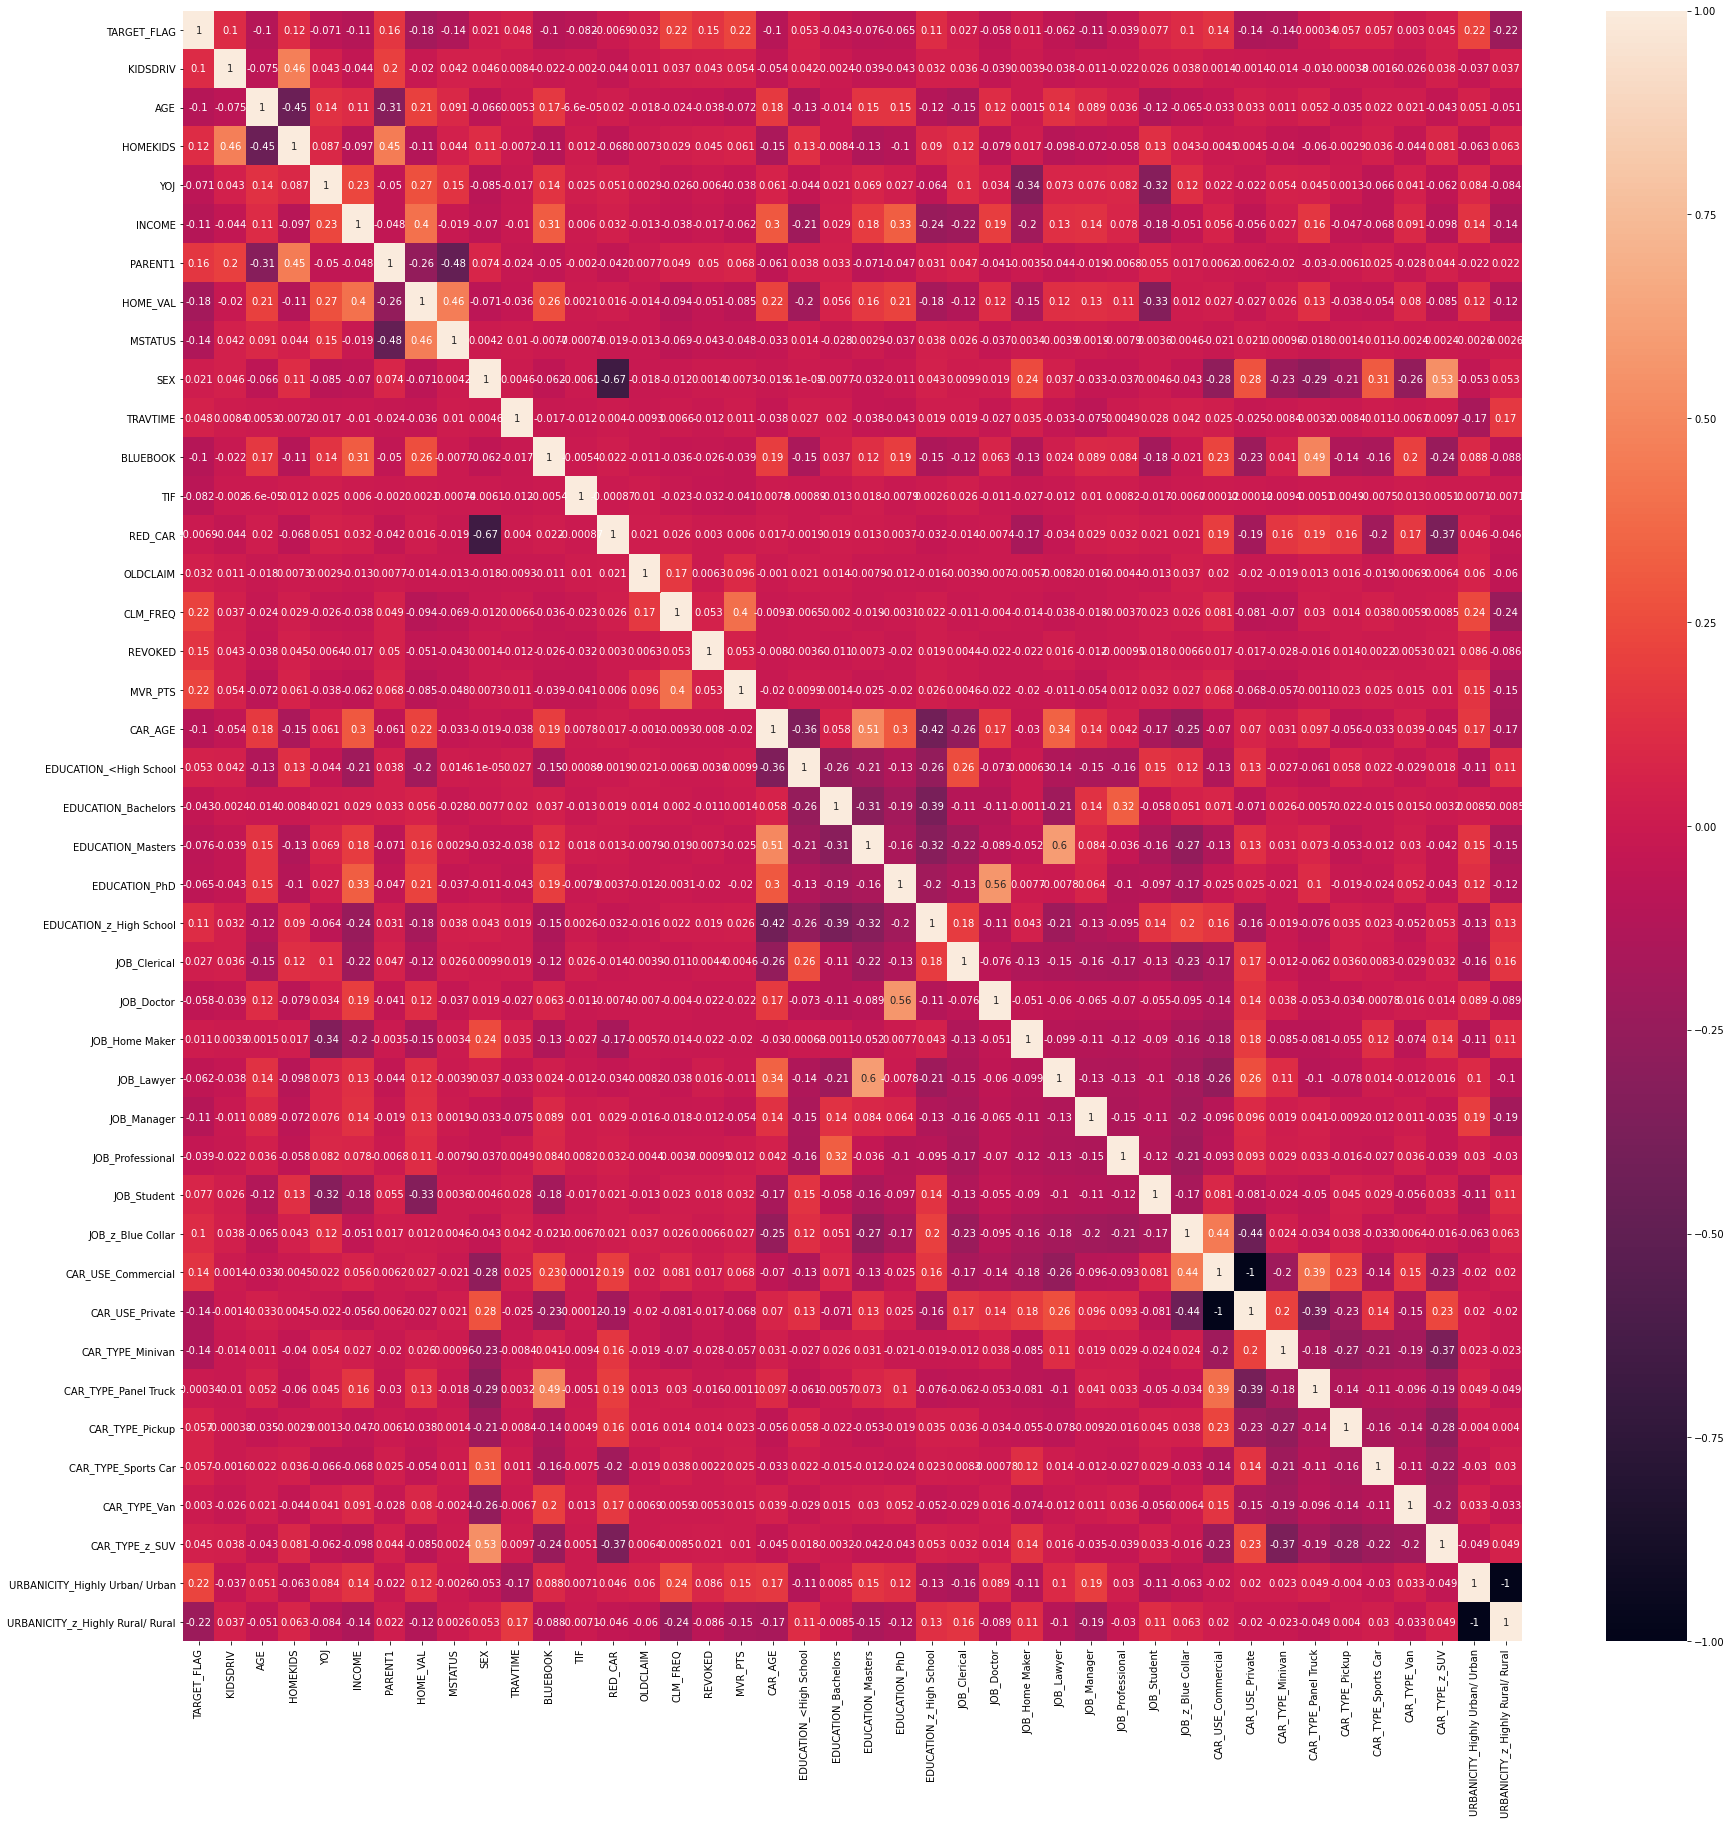

In [30]:
dfeatures.drop('SEX',axis='columns',inplace=True)
dfeatures.drop('RED_CAR',axis='columns',inplace=True)
dfeatures.drop('JOB_Home Maker',axis='columns',inplace=True)
dfeatures.drop('CAR_TYPE_Panel Truck',axis='columns',inplace=True)
dfeatures.drop('CAR_TYPE_Van',axis='columns',inplace=True)

def matrice_correlations(step):
    plt.figure(figsize=(30,30))
    correlation_mat = step.corr()
    sns.heatmap(correlation_mat,annot=True)
    plt.show()
matrice_correlations(features)

On observe bien que les variables sont toutes décorrélées, à l'exception de la variable "URBANICITY_z_Highly Rural/Rural" et "URBANICITY_Highly Urban/Urban". Ceci semble logique puisque la variable initiale "URBANICTY" devait être binaire au départ. Les résultats du test du Chi2 étant les mêmes, on choisit de ne garder que "URBANICITY_Highly Urban/Urban".

In [31]:
dfeatures.drop("URBANICITY_Highly Urban/ Urban",axis='columns',inplace=True)

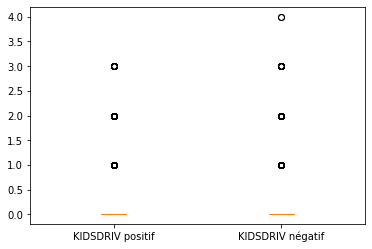

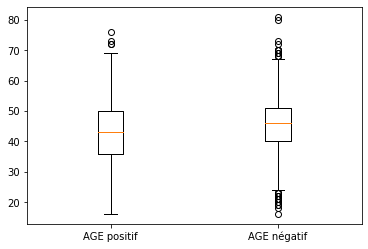

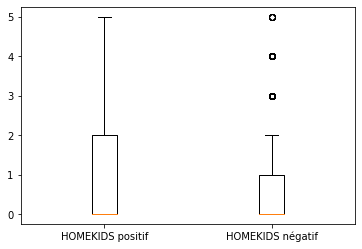

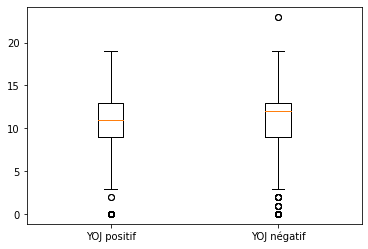

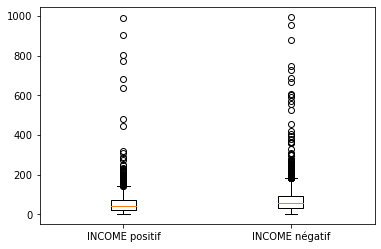

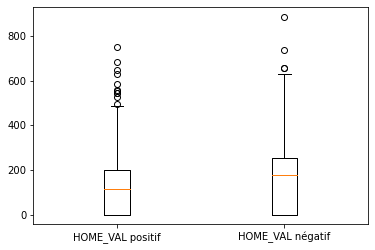

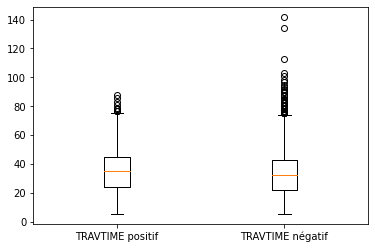

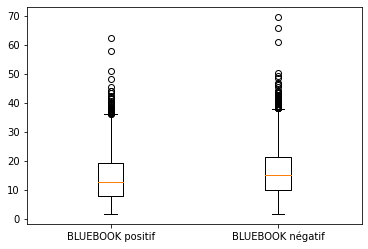

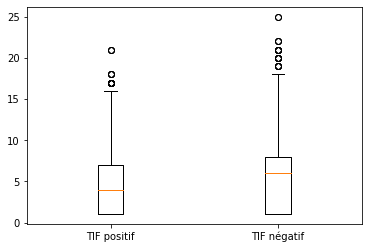

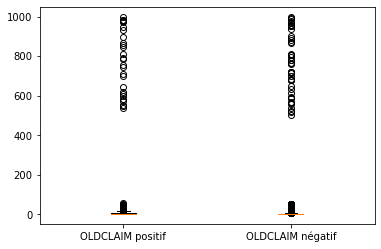

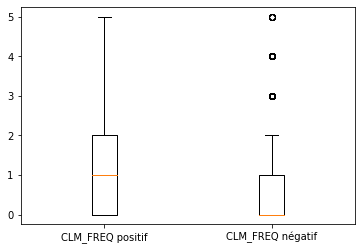

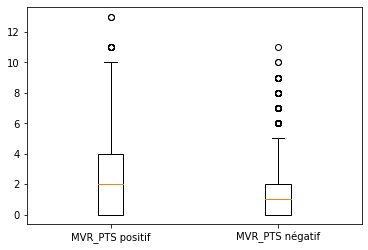

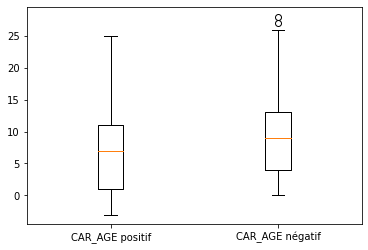

In [32]:
#on affiche les boxplots de chaque variable pour les populations TARGET_FLAG = 0 et TARGET_FLAG = 1
#cela nous permet d'avoir un rendu plus visuel et plus parlant des tests statistiques
def afficheboxplot(data,binaire):
    X = data
    nega, posi = X[X['TARGET_FLAG'] == 0], X[X['TARGET_FLAG'] == 1]
    for i in data.columns:
        if i not in binaire:
            plt.boxplot([posi[i],nega[i]])
            n1,n2 = i+" positif", i+" négatif"
            plt.gca().xaxis.set_ticklabels([n1,n2])
            plt.show()
afficheboxplot(dfeatures,binaire)

In [33]:
#tirage parmi la population TARGET_FLAG = 0 pour avoir en sortie une base de données équilibrée
def equilibre_data(X):
    #on isole la cible
    y = X['TARGET_FLAG']
    nb_posi = np.count_nonzero(y)
    #on mélange les lignes de la population TARGET_FLAG = 0 et on en sélectionne autant qu'il existe de lignes
    #où TARGET_FLAG = 1
    separer = X[X['TARGET_FLAG']==0].to_numpy()
    np.random.shuffle(separer)
    sepa = separer[0:nb_posi]
    X_zero_separe = sepa[:,1:]
    y_zero_separe = separer[0]
    
    #on réassocie les populations TARGET_FLAG = 0 et TARGET_FLAG = 1 en une variable cible et une variable 
    #de données explicatives
    X_separe = np.zeros((2*nb_posi,len(X.columns)-1))
    y_separe = np.zeros((2*nb_posi))
    X_separe[0:np.count_nonzero(y)] = X_zero_separe
    X_separe[np.count_nonzero(y):] = (X[X['TARGET_FLAG']==1].to_numpy())[:,1:]
    y_separe[np.count_nonzero(y):] = 1
    return(X_separe,y_separe)

#la méthode de prédiction choisie est le SVM à noyau linéaire et on choisit
#75% de données en entraînement et 25% de données en test
def SVM(X_separe,y_separe):
    X_train,X_test,y_train,y_test = train_test_split(X_separe,y_separe)
    model = svm.SVC(kernel='linear')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(f"Precision: {round(average_precision_score(y_test, y_pred)*100,2)}%, \t Recall: {round(recall_score(y_test,y_pred)*100,2)}%")
    print(f"Accuray: {round(accuracy_score(y_test,y_pred)*100,2)}%")
    return(y_pred)

X_separe,y_separe = equilibre_data(dfeatures)
y_pred = SVM(X_separe,y_separe)

Precision: 66.15%, 	 Recall: 74.24%
Accuray: 72.42%


Le SVM rend des résultats plutôt moyens. La précision, donc le nombre de TARGET_FLAG = 1 correctement prédits, est de 68%, ce qui est peu mais le recall de 79%. D'où une erreur moyenne totale de 74%, qui peut paraître bonne mais avec une precision pas incroyable dans la vie réelle. Avec plus de temps, un modèle plus adapté aurait été construit afin d'être en mesure de mieux prédire quand il y aura un TARGET_FLAG. 

Le modèle est gardé pour la suite de l'exercice.

In [34]:
#on passe au traitement de la base de données de test
#en prenant en compte toutes les modifications faires précédemment

#base de données préparée
test_features = prep_data('test_auto.csv')

#modification du types des variables concernées en flottant
test_features['OLDCLAIM'] = test_features['OLDCLAIM'].astype(float)
test_features['BLUEBOOK'] = test_features['BLUEBOOK'].astype(float)
test_features['INCOME'] = test_features['INCOME'].astype(float)
test_features['HOME_VAL'] = test_features['HOME_VAL'].astype(float)

#one hot encoding sur le DataFrame
test_features = pd.get_dummies(test_features)

#suppression des variables jugées non indispensables par les tests statistiques  
#et corrélations précédents
test_features.drop('SEX',axis='columns',inplace=True)
test_features.drop('RED_CAR',axis='columns',inplace=True)
test_features.drop('JOB_Home Maker',axis='columns',inplace=True)
test_features.drop('CAR_TYPE_Panel Truck',axis='columns',inplace=True)
test_features.drop('CAR_TYPE_Van',axis='columns',inplace=True)
test_features.drop("URBANICITY_Highly Urban/ Urban",axis='columns',inplace=True)

test_features.describe()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,TRAVTIME,...,JOB_Professional,JOB_Student,JOB_z_Blue Collar,CAR_USE_Commercial,CAR_USE_Private,CAR_TYPE_Minivan,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_z_SUV,URBANICITY_z_Highly Rural/ Rural
count,0.0,2141.000000,2140.000000,2141.000000,2047.000000,2016.000000,2141.000000,2030.000000,2141.000000,2141.000000,...,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000
mean,NaN,0.162541,45.016822,0.717422,10.379091,60.614154,0.124241,153.217671,0.604390,33.152265,...,0.135918,0.087342,0.216254,0.354974,0.645026,0.256422,0.178888,0.127043,0.275105,0.188230
std,NaN,0.486949,8.525006,1.116579,4.170008,47.398516,0.329933,129.456870,0.489095,15.722393,...,0.342781,0.282402,0.411786,0.478617,0.478617,0.436760,0.383348,0.333099,0.446672,0.390987
min,NaN,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,39.000000,0.000000,9.000000,25.886000,0.000000,0.000000,0.000000,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,45.000000,0.000000,11.000000,51.908000,0.000000,158.840000,1.000000,33.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.000000,51.000000,1.000000,13.000000,86.377250,0.000000,236.651500,1.000000,43.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,NaN,3.000000,73.000000,5.000000,19.000000,291.182000,1.000000,669.271000,1.000000,105.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
#on rempalce les valeurs manquantes par la moyenne de la variable concernée, c'est un choix
def missing_value(data):
    for k in data.columns:
        data[k].replace({np.nan:data[k].mean()},inplace=True)
    return(data)
test_features = missing_value(test_features)
test_features.drop('TARGET_FLAG',axis='columns',inplace=True)
test_features.describe()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,TRAVTIME,BLUEBOOK,...,JOB_Professional,JOB_Student,JOB_z_Blue Collar,CAR_USE_Commercial,CAR_USE_Private,CAR_TYPE_Minivan,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_z_SUV,URBANICITY_z_Highly Rural/ Rural
count,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,...,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000
mean,0.162541,45.016822,0.717422,10.379091,60.614154,0.124241,153.217671,0.604390,33.152265,15.469426,...,0.135918,0.087342,0.216254,0.354974,0.645026,0.256422,0.178888,0.127043,0.275105,0.188230
std,0.486949,8.523014,1.116579,4.077395,45.993386,0.329933,126.054757,0.489095,15.722393,8.462367,...,0.342781,0.282402,0.411786,0.478617,0.478617,0.436760,0.383348,0.333099,0.446672,0.390987
min,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,39.000000,0.000000,9.000000,27.499000,0.000000,0.000000,0.000000,22.000000,8.870000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,45.000000,0.000000,11.000000,55.527000,0.000000,153.217671,1.000000,33.000000,14.170000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,51.000000,1.000000,13.000000,82.971000,0.000000,231.739000,1.000000,43.000000,21.050000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,3.000000,73.000000,5.000000,19.000000,291.182000,1.000000,669.271000,1.000000,105.000000,49.940000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
#on applique un SVM
def vrai_svm(X,y,X_test):
    model = svm.SVC(kernel='linear')
    model.fit(X,y)
    y_pred = model.predict(X_test)
    return(y_pred)
y_pred = vrai_svm(X_separe,y_separe,test_features)

In [37]:
#on modifie le fichier csv avec les valeurs TARGET_FLAG prédites
def to_csv(path,y_pred): 
    f = pd.read_csv(path)
    f['TARGET_FLAG'] = y_pred
    # field names  
    fields = f.columns

    # data rows of csv file  
    rows = f.values

    # writing to csv file  
    with open(path, 'w') as csvfile:  
        # creating a csv writer object  
        csvwriter = csv.writer(csvfile)  

        # writing the fields  
        csvwriter.writerow(fields)  

        # writing the data rows  
        csvwriter.writerows(rows) 
        
to_csv("test_auto.csv",y_pred)